# Kangaroo Population

In [1]:
import pandas as pd
#import numpy as np
#import requests
from bs4 import BeautifulSoup

In [2]:
#url = 'https://www.dcceew.gov.au/environment/wildlife-trade/natives/wild-harvest/kangaroo-wallaby-statistics/kangaroo-population'

## Data

In [3]:
data = open("kangaroo_html.txt", "r").read()

In [4]:
soup = BeautifulSoup(data, 'html.parser')

### Parse HTML

In [5]:
# Open Write File
with open('kangaroo.csv', 'w', encoding='utf-8') as csv_data:

    # Write Column Headers
    th_count = 0
    th_max = 5
    for table in soup.find_all("table"):
        if th_count < th_max:
            year = table.find('a').string[:4]
            csv_data.write('Year')
            for th in table.find_all("th"):
                th_count += 1
                if th_count <= th_max:
                    start = str(th).find('>') + 1
                    end = str(th)[start+1:].find('<') + start + 2
                    string = str(th)[start:end]
                    string = string[:string.find('/')] 
                    csv_data.write(',' + string)
    csv_data.write('\n')

    # Write Column Data
    for table in soup.find_all("table"):
        year = table.find('a').string[:4]
        td_count = 0
        total_row = False
        wrote_year = False
        for td in table.find_all("td"):
            td_count += 1
            if td_count <= th_max:
                if td.string.find('Total') == -1 and str(td).find('<strong>') == -1 and not total_row:
                    if td_count == 1:
                        csv_data.write(year)
                        wrote_year = True
                    string = td.string.replace(',','')
                    string = string.replace('-','0')
                    if td_count > 1:
                        try:
                            x = int(string)
                        except:
                            string = '0'
                    csv_data.write(',' + string)
                else:
                    total_row = True
            else:
                if wrote_year:
                    csv_data.write('\n')
                td_count = 0
                total_row = False
                wrote_year = False

### Read to Dataframe

In [6]:
df = pd.read_csv('./kangaroo.csv', encoding='utf-8')  

In [7]:
df.head(4)

,Year,State,Red,Western Grey,Eastern Grey,Wallaroo
0,2011,South Australia,1158000,674800,0,494800
1,2011,Western Australia,638185,1177534,0,0
2,2011,New South Wales,3972522,496059,5258104,88430
3,2011,Queensland,5745591,0,10799679,3799973


## Wrangling

In [8]:
df.shape

(44, 6)

In [9]:
no_nulls = True
for column, null_count in df.isnull().sum().items():
    if null_count > 0:
        no_nulls = False
        print(f'{column}:   {null_count}')
if no_nulls:
    print('No Nulls')

No Nulls


In [10]:
df.dtypes

Year             int64
State           object
Red              int64
Western Grey     int64
Eastern Grey     int64
Wallaroo         int64
dtype: object

## Visualization

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [13]:
colors = ['#ff3d44', '#ffb85c', '#fcfa62', '#80f569', '#74eafc', '#e969f5']
#          red        orange     yellow     green      blue       violet
colors = ['#ff3d44', '#74eafc', '#80f569', '#ffb85c', '#e969f5', '#fcfa62']
#          red        blue       green      orange     violet     yellow

### Greys by Year for Region

In [13]:
df_wg = df[['Year','State','Western Grey']]
df_wg = df_wg[df_wg['Western Grey'] != 0].groupby(['Year', 'State']).sum()
df_wg = df_wg.pivot_table(values='Western Grey', index='Year', columns='State')
df_wg = df_wg.reset_index()
df_wg.rename_axis(None, axis=1, inplace=True)
df_wg.head(3)

,Year,New South Wales,South Australia,Western Australia
0,2001,2031612.0,751000.0,642380.0
1,2002,2387589.0,810000.0,566700.0
2,2003,1265031.0,679000.0,666900.0


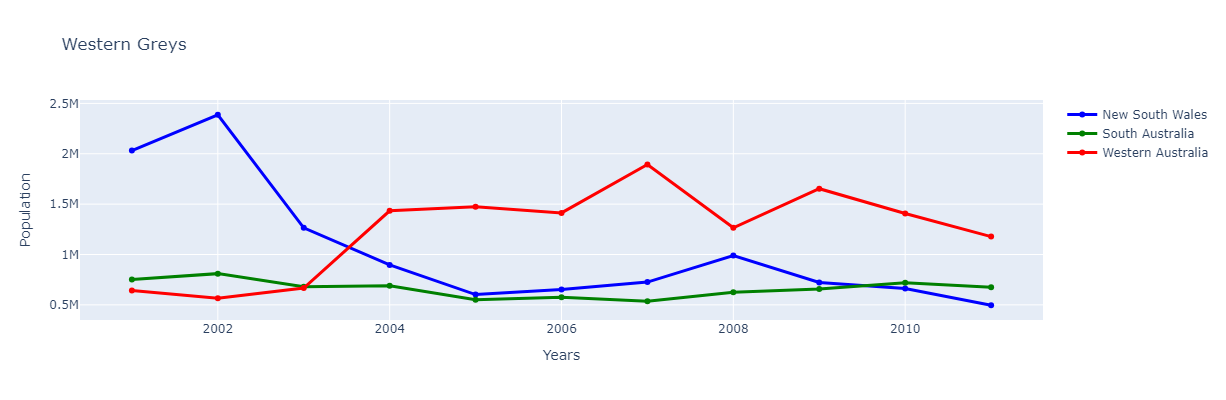

In [21]:
fig = go.Figure()
for i in range(len(df_wg.columns[1:])):
    fig.add_trace(go.Scatter(x=df_wg.Year.to_list(), y=df_wg[df_wg.columns[1:][i]].to_list(), mode='markers+lines', name=df_wg.columns[1:][i], marker=dict(color=colors[i])))
fig.update_traces(line=dict(width=3.0))    
fig.update_layout(title='Western Greys', xaxis_title='Years', yaxis_title='Population', width=1000, height=400)

###  Types by Year

In [15]:
df_t = df.groupby(['Year']).sum()
df_t.drop('State', axis=1, inplace=True)
df_t.reset_index(inplace=True)
df_t.head(3)

,Year,Red,Western Grey,Eastern Grey,Wallaroo
0,2001,17434513,3424992,29721271,6849250
1,2002,13633816,3764289,23383249,3064178
2,2003,8727856,2610931,13875828,2999906


In [16]:
fig = go.Figure()
for i in range(len(df_t.columns[1:])):
    fig.add_trace(go.Scatter(x=df_t.Year.to_list(), y=df_t[df_t.columns[1:][i]].to_list(), opacity = 0.5, mode='lines', name=df_t.columns[1:][i], marker=dict(color=colors[i])))
fig.update_traces(line=dict(width=4.0))   
fig.update_layout(title='Kangaroos', xaxis_title='Years', yaxis_title='Population', width=1000, height=400)

### Population Average by Type

In [17]:
df_w = df.groupby(['Year']).sum()
df_w.drop('State', axis=1, inplace=True)
df_w = df_w.T
df_w['Average'] = df_w.mean(axis=1)
df_w = df_w[['Average']]
df_w

Year,Average
Red,9.983796e+06
Western Grey,2.935825e+06
Eastern Grey,1.447194e+07
Wallaroo,3.468019e+06


In [18]:
fig = px.pie(values=df_w.Average, names=df_w.index, hole=.5, title='Kangaroos')
fig.update_layout(
    width=650, height=650,
    title_x=1/2, title_y=7/12,
    legend=dict(
        yanchor="bottom",
        y=2/5,
        xanchor="left",
        x=3/8))
fig.show()

### State by Year

In [19]:
df_s = df
df_s['Total'] = df_s.sum(axis=1, numeric_only=True)
df_s = df_s[['Year','State','Total']]
df_s = df_s.groupby(['Year', 'State']).mean()
df_s = df_s.pivot_table(values='Total', index='Year', columns='State').reset_index()
df_s.rename_axis(None, axis=1, inplace=True)
df_s.head(2)

,Year,New South Wales,Queensland,South Australia,Western Australia
0,2001,14433247.0,37576301.0,2929001.0,2499481.0
1,2002,15930606.0,22858130.0,2746002.0,2318802.0


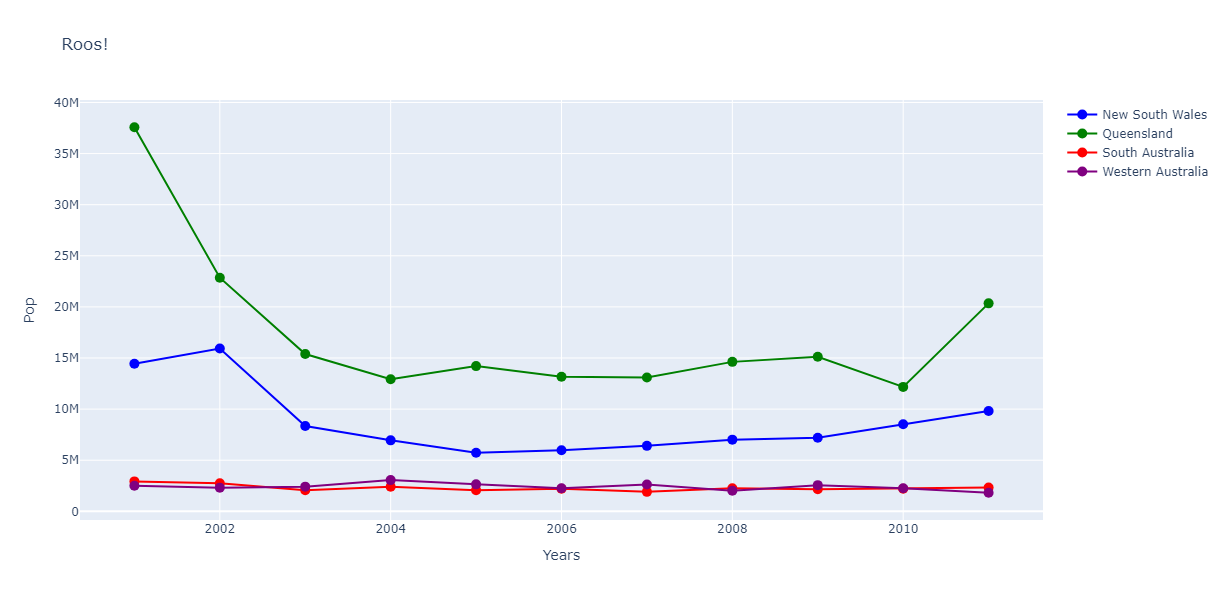

In [22]:
fig = go.Figure()
for i in range(len(df_s.columns[1:])):
    fig.add_trace(go.Scatter(x=df_s.Year.to_list(), y=df_s[df_s.columns[1:][i]].to_list(), mode='markers+lines', marker=dict(color=colors[i], size=10), name=df_s.columns[1:][i]))
fig.update_layout(title='Roos!', xaxis_title='Years', yaxis_title='Pop', width=1000, height=600)
fig.show()